# Model Training

In [87]:
%matplotlib inline
import glob
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [88]:
filenames = glob.glob("data/features/*.csv")
converters={"failure": str}
dfs= [pd.read_csv(filename, converters=converters) for filename in filenames]
combined_df = pd.concat(dfs, ignore_index=True)

In [89]:
w = 7
seed = 42

max_cycles = combined_df.join(combined_df[(combined_df.rul.isna())]
                              .groupby(['machineID'], as_index=False).cycle
                              .agg(['max', 'count']).apply(lambda x: x['max'] - min(x['count'], w), axis = 1)
                              .to_frame(name='max_cycle'), on='machineID')

data = max_cycles[max_cycles.max_cycle.isna() | (max_cycles.cycle <= max_cycles.max_cycle)].drop('max_cycle', axis=1)

In [90]:
lookback = 5
test_size = 0.2
time_split = True

if time_split:
    data.set_index(['timestamp', 'machineID'], inplace=True)
    data.sort_index(inplace=True)

    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    
    min_cycles = test.reset_index().groupby(['machineID']).cycle.min().apply(lambda x: x - lookback).to_frame(name='max_cycle')
    t = train.reset_index().join(min_cycles, on='machineID')
    train = t[t.max_cycle.isna() | (t.cycle < t.max_cycle)].drop('max_cycle', axis=1)
    train.set_index(['timestamp', 'machineID'], inplace=True)
else:
    # asset split
    unique_assets = data.reset_index().machineID.unique()
    train_assets, test_assets = train_test_split(unique_assets, test_size=test_size, random_state=seed)
    train = data[data.machineID.isin(train_assets)]
    test = data[data.machineID.isin(test_assets)]
    train.set_index(['timestamp', 'machineID'], inplace=True)
    test.set_index(['timestamp', 'machineID'], inplace=True)

In [91]:
clf = RandomForestClassifier(random_state=seed)

def xy(data, w):
    data = data.reset_index(drop = True)
    return (data.drop(['cycle', 'failure', 'rul', 'sequenceID'], axis=1),
            data.apply(lambda row: row.failure if row.rul and row.rul < w else '', axis=1))

# tscv = TimeSeriesSplit(n_splits=6)
# cross_val_score(clf, X, Y, cv=tscv)

# for train_index, test_index in tscv.split(X):
#     train = X[[train_index]]
#     test = X[[test_index]]

X_train, Y_train = xy(train, w)
X_test, Y_test = xy(test, w)

sm = SMOTE(random_state=seed)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
#X_train_res, Y_train_res = X_train, Y_train

clf.fit(X_train_res, Y_train_res)

c = Counter(Y_test)
c

Counter({'': 11356, 'F1': 434, 'F2': 148})

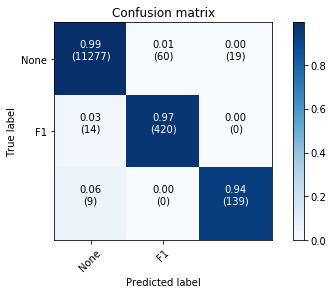

In [92]:
Y_predictions = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    orig = cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + '\n({0})'.format(orig[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(Y_test, Y_predictions)
plot_confusion_matrix(cm, ['None', 'F1'])

In [93]:
accuracy_score(Y_test, Y_predictions)

0.9914558552521361

In [94]:
Y_test.where(Y_test != 'F1').count()

11504